# Mental Health Screening Checklist

In [1]:
# imports
import pickle
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.patches import FancyBboxPatch
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from pyod.models.iforest import IForest
from IPython.display import display_html 

# customize pandas
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# customize matplolib
rcParams['font.family'] = ['Trebuchet MS']

In [2]:
# load dataset
df = pd.read_csv(
    "./data/mhsc_training_dataset.csv", 
    index_col=0,
    dtype={ c: "category" for c in ["bio_gender", "bio_age", "bio_job"] }
)

df.bio_job = df.bio_job.cat.reorder_categories(['Pilot', 'Pilot Applicant', 'Cabin Crew'], ordered=True)

# 1. GENERAL STATS

## 1.1 BIOGRAPHICAL DATA

In [3]:
# generate table for biographical data
def make_table_bio(df, col):
    table = df[col].agg({ 
        "%" : lambda x: x.value_counts(normalize=True).mul(100),
        "Freq" : lambda x: x.value_counts(),
    }).unstack(level=0).reset_index(drop=False)
    
    return (table
         .style
            .hide()
            .hide(subset=table[table.eq(0).any(axis=1)].index, axis=0)
            .format(precision=1, subset="%")
            .format(precision=0, subset="Freq")
            .relabel_index([c.split("_")[-1] for c in table.columns], axis=1)
            .set_table_attributes("style='display:inline;margin-right:48px'")
            .to_html()
)

In [4]:
html = ""
for col in df.filter(regex="bio_(?!status)"):
    html += make_table_bio(df, col)
    
display_html(html, raw=True)

gender,%,Freq
M,88.8,213
F,11.2,27
age,%,Freq
17-30,46.7,112
31-50,33.8,81
51-99,19.6,47
job,%,Freq
Pilot,52.5,126
Pilot Applicant,32.1,77
Cabin Crew,15.4,37


## 1.2 ITEM ENDORSMENT RATES

In [5]:
# generate table for mhsc parts
def make_mhsc_part_table(part):

    table = (    
        df
            .filter(regex=f"bio_job|{part}")
            .set_index("bio_job")
            .gt(0)
            .reset_index(drop=False)
            .groupby("bio_job", observed=True)
            .sum()
            .T
    )
    
    return (
        table
            .div(table.sum(axis=1), axis=0)
            .fillna(0)
            .mul(100)
            .reset_index(drop=False)
            .style
                .hide()
                .format(precision=1)
                .background_gradient(cmap="GnBu", axis=1)
                .set_properties(**{'width': '120px'})
                .set_table_styles([
                    { "selector": "td", "props": [('text-align', 'center')]},
                    { "selector": "th", "props": [('text-align', 'center')]},
                ])
    )

### 1.2.1 MHSC PART 1

In [6]:
make_mhsc_part_table("mhsc_01")

index,Pilot,Pilot Applicant,Cabin Crew
mhsc_01_01,15.0,15.0,70.0
mhsc_01_02,13.6,36.4,50.0
mhsc_01_03,0.0,0.0,100.0
mhsc_01_04,20.0,20.0,60.0
mhsc_01_05,100.0,0.0,0.0
mhsc_01_06,33.3,16.7,50.0
mhsc_01_07,45.5,18.2,36.4
mhsc_01_08,39.1,30.4,30.4
mhsc_01_09,38.5,15.4,46.2
mhsc_01_10,28.6,42.9,28.6


### 1.2.2 MSHC PART 2

In [7]:
make_mhsc_part_table("mhsc_02")

index,Pilot,Pilot Applicant,Cabin Crew
mhsc_02_01,52.2,33.0,14.8
mhsc_02_02,51.2,34.6,14.2
mhsc_02_03,46.8,29.8,23.4
mhsc_02_04,0.0,0.0,0.0
mhsc_02_05,0.0,0.0,0.0


### 1.2.3 MSHC PART 3

In [8]:
make_mhsc_part_table("mhsc_03")

index,Pilot,Pilot Applicant,Cabin Crew
mhsc_03_01,0.0,62.5,37.5
mhsc_03_02,0.0,100.0,0.0
mhsc_03_03,66.7,33.3,0.0
mhsc_03_04,33.3,33.3,33.3
mhsc_03_05,100.0,0.0,0.0


# 2. MHSC OUTLIER DETECTION PIPE

## 2.1 Pipiline outline graph

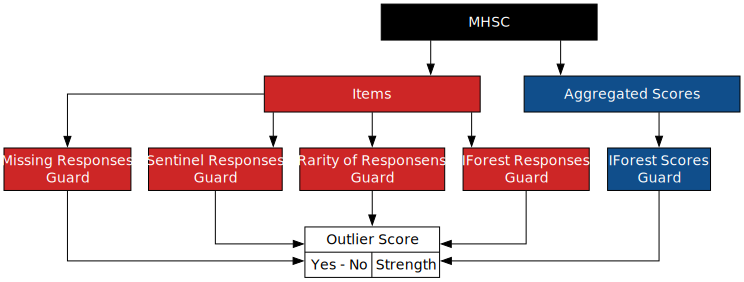

In [10]:
from graphviz import Source
# Create Digraph object
src = '''
digraph G {
  fontname="Trebuchet MS,Helvetica,Arial,sans-serif"
  node [fontname="Trebuchet MS,Helvetica,Arial,sans-serif"]
  edge [fontname="Trebuchet MS,Helvetica,Arial,sans-serif"]
  splines=ortho
  subgraph {
    2 [shape=box, label="MHSC", width=3, style=filled, fillcolor="black", fontcolor="white"]
    3 [shape=box label="Items", width=3, style=filled, fillcolor="firebrick3", fontcolor="white"]
    4 [shape=box label="Aggregated Scores", width=3, style=filled, fillcolor="dodgerblue4", fontcolor="white"]
    5 [shape=box, label="Missing Responses\nGuard", style=filled, fillcolor="firebrick3", fontcolor="white"]
    6 [shape=box, label="Sentinel Responses\nGuard", style=filled, fillcolor="firebrick3", fontcolor="white"]
    7 [shape=box, label="Rarity of Responsens\nGuard", style=filled, fillcolor="firebrick3", fontcolor="white"]
    8 [shape=box, label="IForest Responses\nGuard", style=filled, fillcolor="firebrick3", fontcolor="white"]
    9 [shape=box, label="IForest Scores\nGuard", style=filled, fillcolor="dodgerblue4", fontcolor="white"]
    10 [shape=record label="{ Outlier Score |{Yes - No|Strength}}" ]
    2 -> {3; 4;}
    3 -> {5;6;7;8}
    4 -> 9
    {5;6;7;8;9;} -> 10;
  }
}
'''
flow = Source(src)
flow.render("./media/flow")
Source(src)

## 2.2 Pre train relevant steps of pipeline

### A word of caution to the reader

In the current implementation, some steps of the outrlier detection pipe are trained on the given dataset, which contains individuals with dirrent demographic signatures and job profiles.
A better approach would be to segment the popultion of interest in different groups and training several outlier detectin pipes on such groups.

In [11]:
# get unique/rare sequences
def get_common_sequences(df, threshold = 2):
    # count sequences in df
    sequences_counts =  df.filter(regex="mhsc_01|mhsc_03").astype(str).sum(axis=1).value_counts()
    # list of rare sequences
    common_sequences = set((sequences_counts[sequences_counts >= threshold]).index.to_list())
    # return rare sequences
    return common_sequences

# get isolation forests
def get_isofs(df):
    # compute aggregated scores
    df["mhsc_part01_tot"] = df.filter(regex="mhsc_01").sum(axis=1)
    df["mhsc_part02_tot"] = df.filter(regex="mhsc_02").sum(axis=1)
    df["mhsc_part03_tot"] = df.filter(regex="mhsc_03").sum(axis=1)
    df["mhsc_part04_tot"] = df.filter(regex="mhsc_04").sum(axis=1)
    # get data for isolations forests
    df_mhsc_items = df.filter(regex="mhsc_\d")
    df_mhsc_parts = df.filter(regex="mhsc_part")
    # fit isolation forests
    isof_items, isof_parts = IForest(random_state = 42), IForest(random_state = 42)
    isof_items.fit(df_mhsc_items)
    isof_parts.fit(df_mhsc_parts)  
    # return isolation forests
    return isof_items, isof_parts

## 2.3 Pipeline

### 2.3.1 Definiotion of MHSC Pipeline Class

In [13]:
class MHSC_pipe():

    def __init__(self, common_sequences, isof_items, isof_parts):
        self.common_sequences = common_sequences
        self.isof_items = isof_items
        self.isof_parts = isof_parts

    def compute_aggregated_scores(self, df):
        # compute aggregated scores
        df["mhsc_part01_tot"] = df.filter(regex="mhsc_01").sum(axis=1)
        df["mhsc_part02_tot"] = df.filter(regex="mhsc_02").sum(axis=1)
        df["mhsc_part03_tot"] = df.filter(regex="mhsc_03").sum(axis=1)
        df["mhsc_part04_tot"] = df.filter(regex="mhsc_04").sum(axis=1)
        # return df
        return df

    def missing_items_guard(self, df):
        # -1: there are missing items
        # 1: no missing items
    
        # sum missing items
        missing_items = df.filter(regex="mhsc").isna().sum(axis=1)
        # compute outlier missing
        df["outlier_missing"] = missing_items.case_when([ (missing_items.gt(0), -1), (missing_items.eq(0), 1) ])
        
        # return df
        return df

    def sentinel_items_guard(self, df):
        # -1: at least 1 sentinel item is positive or psychological well being is < 6
        # 1: sentinel items are all negative and psychological well being is >= 6
        
        # sum sentinel items
        sentinel_items = df[["mhsc_01_05", "mhsc_02_04", "mhsc_02_05", "mhsc_03_01", "mhsc_03_05"]].gt(0).sum(axis=1)
        # compute outlier sentinel
        df["outlier_sentinel"] = sentinel_items.case_when([ (sentinel_items.gt(0), -1), (sentinel_items.eq(0), 1) ])
        # update outlier sentinel with psychological well being condition
        df.loc[df["mhsc_04_01"] < 6, "outlier_sentinel"] = -1
        
        # return df
        return df

    def rarity_of_sequence_guard(self, df, common_sequences):
        # -1: items sequence is unique/rare
        # 1: items sequence is not unique/rare
    
        # get current sequences
        current_sequences = df.filter(regex="mhsc_01|mhsc_03").astype(str).sum(axis=1)
        # check whether current sequences are rare/unique
        df["outlier_uniqueness"] = np.where(current_sequences.isin(common_sequences), 1, -1)
        
        # return df
        return df


    def isofs_guard(self, df, isof_items, isof_parts):
        # -1 isolation forest predict observation to be outlier
        # 1 isolation forest predict observation to be inlier
        
        # set constant threshold
        OUTLIER_THRESHOLD = .9
        # filter data to feed isolation forests
        df_mhsc_items = df.filter(regex="mhsc_\d")
        df_mhsc_parts = df.filter(regex="mhsc_part") 
        # set isofs
        isofs = [
            ("isof_items", isof_items, df_mhsc_items, OUTLIER_THRESHOLD), 
            ("isof_parts", isof_parts, df_mhsc_parts, OUTLIER_THRESHOLD),
        ]
        # compute isolation forests
        for label, isof, data, threshold in isofs:
            decision_col, outlier_col = f"decision_{label}", f"outlier_{label}"
            df[decision_col] = isof.decision_function(data.values)
            df[outlier_col] = np.where(df[decision_col] >= df[decision_col].quantile(threshold), -1, 1)
        
        # return df
        return df

    def compute_outlier_score(self, df):
        # add outlierness score
        df["outlier_score"] = df.filter(regex="outlier(?!ness_score|_type)").replace(1,0).abs().mean(axis=1)
        # add interpretation of outlierness score
        df["outlier_type"] = df["outlier_score"].case_when(
            [
                (df["outlier_score"].eq(0), "no outlier"),
                (df["outlier_score"].between(0, .25, inclusive="right"), "moderate outlier"),
                (df["outlier_score"].between(.25, .75, inclusive="neither"), "strong outlier"),
                (df["outlier_score"].between(.75, 1, inclusive="both"), "extreme outlier"),
            ]
        )
        
        # return df
        return df
    
    def run_pipe(self, df):
        return (df
                .pipe(self.compute_aggregated_scores)
                .pipe(self.missing_items_guard)
                .pipe(self.sentinel_items_guard)
                .pipe(self.rarity_of_sequence_guard, common_sequences = self.common_sequences)
                .pipe(self.isofs_guard, isof_items=self.isof_items, isof_parts=self.isof_parts)
                .pipe(self.compute_outlier_score)
             )

### 2.3.2 Application of Pipe

In [14]:
common_sequences = get_common_sequences(df)
isof_items, isof_parts = get_isofs(df)

# create mhsc pipe
pipe = MHSC_pipe(common_sequences, isof_items, isof_parts)

# dump mhsc pipe to pickle file
with open("./pickle/mhsc_pipe.pkl", 'wb') as fout:
    pickle.dump(pipe, fout, pickle.HIGHEST_PROTOCOL)

# init mhsc pipe
pipe = MHSC_pipe(common_sequences, isof_items, isof_parts)

# run pipe
df = pipe.run_pipe(df)

df.head(2)

,bio_gender,bio_age,bio_job,mhsc_01_01,mhsc_01_02,mhsc_01_03,mhsc_01_04,mhsc_01_05,mhsc_01_06,mhsc_01_07,mhsc_01_08,mhsc_01_09,mhsc_01_10,mhsc_02_01,mhsc_02_02,mhsc_02_03,mhsc_02_04,mhsc_02_05,mhsc_03_01,mhsc_03_02,mhsc_03_03,mhsc_03_04,mhsc_03_05,mhsc_04_01,mhsc_part01_tot,mhsc_part02_tot,mhsc_part03_tot,mhsc_part04_tot,outlier_missing,outlier_sentinel,outlier_uniqueness,decision_isof_items,outlier_isof_items,decision_isof_parts,outlier_isof_parts,outlier_score,outlier_type
bio_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,F,17-30,Cabin Crew,1,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,7,1,4,0,7,1,1,1,-0.056392,1,-0.061204,1,0.0,no outlier
2,F,17-30,Cabin Crew,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,8,1,1,1,-0.167555,1,-0.115000,1,0.0,no outlier


# 3. IDENTIFIED OUTLIERS

## 3.1 Count and percentages of outliers

In [15]:
# outliers count
count_of_outliers = df.filter(regex="outlier_").apply(lambda x: (x==-1).any(), axis=1).sum().astype(int)
# percentageof outliers
perc_of_otuliers = round(count_of_outliers / df.shape[0] * 100, 1)

# table
(
    pd.DataFrame({
        "Total observations": [df.shape[0]],
        "Count of outliers": [count_of_outliers], 
        "% of outliers over total": [perc_of_otuliers]})
        .style
            .hide()
            .format(precision=2)
)

Total observations,Count of outliers,% of outliers over total
240,42,17.50


## 3.2 Percentages of outliers captured by pipeline steps

In [16]:
outliers_columns = df.filter(regex="outlier_(?!type)").columns.to_list()

outliers_by_step = df.loc[(df[outliers_columns] == -1).any(axis=1), outliers_columns]

def get_type_of_detection_strategy(x):
    x = x.iloc[:, :-1].astype(int).T
    return x.apply(
        lambda y: y.index[y==-1].to_list()[0] if y.clip(-1,0).sum() == -1 
            else "any combination of steps", axis=0
    )

(
    (outliers_by_step
        .value_counts(normalize=True, sort=False)
        .reset_index(drop=False)
        .sort_values(by=outliers_columns)
        .assign(strategy=lambda x: get_type_of_detection_strategy(x))
        .groupby("strategy")[["proportion"]]
            .sum().sort_values(by="proportion", ascending=False)
        .reset_index(drop=False)
        .rename(columns={"strategy":"Outliers detectd by","proportion":"%"})
        .style
            .hide()
            .format(lambda x: round(x*100, 1), subset=["%"])
    )
)

Outliers detectd by,%
any combination of steps,69.0
outlier_uniqueness,14.3
outlier_isof_parts,9.5
outlier_sentinel,4.8
outlier_isof_items,2.4


## 3.3 Percentages of outliers in dataset by outlierness score

In [17]:
# select outlier columns (except missing, as in our dataset there are no profiles with missing items)
outliers_columns = df.filter(regex="outlier_(?!missing)").columns.to_list()

outlier_scores = (
    df
        .pivot_table(index=outliers_columns, values="bio_gender", aggfunc=np.size, observed=True)
        .reset_index(drop=False)
        .groupby("outlier_type")[["bio_gender"]]
            .sum().div(df.shape[0])
)

(
    (outlier_scores
        .reindex(["no outlier", "moderate outlier","strong outlier","extreme outlier"])
        .reset_index(drop=False)
        .rename(columns={"index":"Type of outlier", "bio_gender": "%"})
        .style
            .hide()
            .format(lambda x: round(x*100, 1), subset=["%"])
    )
)

outlier_type,%
no outlier,82.5
moderate outlier,5.4
strong outlier,9.6
extreme outlier,2.5


## 3.4  Percentages of type of outliers type by job

In [18]:
outliers_columns = [f"outlier_{o}" for o in ["sentinel", "uniqueness", "isof_items", "isof_parts", "type" ]]

outlier_scores_by_job = (df.pivot_table(
    index=outliers_columns, columns="bio_job", values="bio_gender", fill_value=0, aggfunc=np.size, observed=False)
     .reset_index(drop=False)
)

table = (outlier_scores_by_job
        .iloc[:,-4:].groupby("outlier_type").agg('sum'))
(
    table
        .transform(lambda x: x/x.sum(axis=0))
        .reindex(["no outlier","moderate outlier", "strong outlier", "extreme outlier"])
        .reset_index(drop=False)
        .style
            .hide()
            .background_gradient(cmap="GnBu", axis=1)
            .format(lambda x: round(x*100, 1), subset=["Pilot","Pilot Applicant","Cabin Crew"])
            .set_properties(**{'width': '120px'})
            .set_table_styles([
                            { "selector": "td", "props": [('text-align', 'center')]},
                            { "selector": "th", "props": [('text-align', 'center')]},
                        ])
)

outlier_type,Pilot,Pilot Applicant,Cabin Crew
no outlier,88.1,79.2,70.3
moderate outlier,6.3,5.2,2.7
strong outlier,5.6,13.0,16.2
extreme outlier,0.0,2.6,10.8


# 4 Outliers plots

## 4.1 Data for plots

In [19]:
SPLINES_COLOR = "#204571"

In [20]:
# pre process data
X_items = df.filter(regex="mhsc_\d")
X_items = MinMaxScaler().fit_transform(X_items)

X_parts = df.filter(regex="mhsc_part")
X_parts = MinMaxScaler().fit_transform(X_parts)

In [21]:
# init pip steps
min_max = MinMaxScaler()
svd = TruncatedSVD()

# define pipe
pipe = Pipeline(steps=[("min_max", min_max),('svd', svd)])

# add truncated SVD factors
data = pd.concat([
    df.reset_index(drop=False), 
    pd.DataFrame(pipe.fit_transform(df.filter(regex="mhsc_\d")))
], axis=1)

# rename columns
data.columns = [*data.columns[:-2], "f1", "f2"]

# show df
data.head()

,bio_id,bio_gender,bio_age,bio_job,mhsc_01_01,mhsc_01_02,mhsc_01_03,mhsc_01_04,mhsc_01_05,mhsc_01_06,mhsc_01_07,mhsc_01_08,mhsc_01_09,mhsc_01_10,mhsc_02_01,mhsc_02_02,mhsc_02_03,mhsc_02_04,mhsc_02_05,mhsc_03_01,mhsc_03_02,mhsc_03_03,mhsc_03_04,mhsc_03_05,mhsc_04_01,mhsc_part01_tot,mhsc_part02_tot,mhsc_part03_tot,mhsc_part04_tot,outlier_missing,outlier_sentinel,outlier_uniqueness,decision_isof_items,outlier_isof_items,decision_isof_parts,outlier_isof_parts,outlier_score,outlier_type,f1,f2
0,1,F,17-30,Cabin Crew,1,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,7,1,4,0,7,1,1,1,-0.056392,1,-0.061204,1,0.0,no outlier,1.114113,0.378599
1,2,F,17-30,Cabin Crew,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,8,1,1,1,-0.167555,1,-0.115000,1,0.0,no outlier,0.493377,-0.236792
2,3,M,17-30,Pilot,0,0,0,0,0,0,0,0,0,0,3,1,3,0,0,0,0,0,0,0,9,0,7,0,9,1,1,1,-0.121538,1,-0.062365,1,0.0,no outlier,1.403823,-0.121519
3,4,M,17-30,Pilot Applicant,0,0,0,0,0,0,1,0,0,0,2,1,0,0,0,0,0,0,1,0,8,1,3,1,8,1,1,-1,-0.027645,1,-0.024167,1,0.2,moderate outlier,1.021917,0.056914
4,5,M,31-50,Cabin Crew,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,8,0,1,0,8,1,1,1,-0.172826,1,-0.174158,1,0.0,no outlier,0.581983,-0.238403


## 4.2 Scatterplot of outliers by pipeline steps

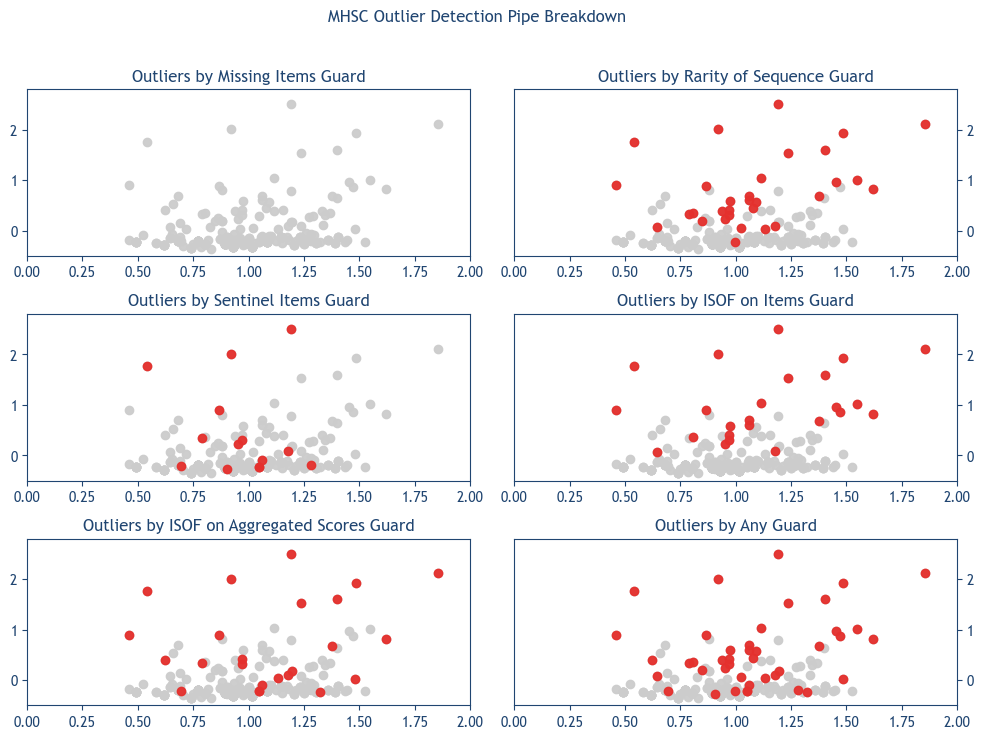

In [35]:
fig = plt.figure(figsize=(12,8))

gs = GridSpec(3, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])

ALPHA = .95

for algo, ax in zip(
    ["missing", "uniqueness", "sentinel", "isof_items", "isof_parts", "score"], 
    [ax1, ax2, ax3, ax4, ax5, ax6]
):
    outliers_mask =  data.loc[:, [f"outlier_{algo}"]].replace(1,0).abs().gt(0).sum(axis=1) > 0
    ax.scatter(data["f1"], data["f2"], c="#ccc", alpha=ALPHA)
    ax.scatter(
        data.loc[outliers_mask, "f1"], 
        data.loc[outliers_mask, "f2"], 
        c="#e5302d", 
        alpha=ALPHA
    )
    #for index, row in data.copy().reset_index(drop=False).iterrows():
        #ax.annotate(row["bio_id"], (row["svd_f1"], row["svd_f2"]))
        
    
for idx, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6], 1):
    if idx % 2 == 0: ax.yaxis.tick_right() 
    ax.set_xlim(0, 2)
    ax.set_ylim(-.5, 2.8)
    
    ax.tick_params(color=SPLINES_COLOR, labelcolor=SPLINES_COLOR)
    for spine in ax.spines.values():
        spine.set_edgecolor(SPLINES_COLOR)

fig.suptitle("MHSC Outlier Detection Pipe Breakdown", c=SPLINES_COLOR)
ax1.set_title("Outliers by Missing Items Guard", c=SPLINES_COLOR)
ax2.set_title("Outliers by Rarity of Sequence Guard", c=SPLINES_COLOR)
ax3.set_title("Outliers by Sentinel Items Guard", c=SPLINES_COLOR)
ax4.set_title("Outliers by ISOF on Items Guard", c=SPLINES_COLOR)
ax5.set_title("Outliers by ISOF on Aggregated Scores Guard", c=SPLINES_COLOR)
ax6.set_title("Outliers by Any Guard", c=SPLINES_COLOR)

plt.subplots_adjust(wspace=0.1, hspace=.35)
plt.savefig("./media/plot1.pdf", bbox_inches='tight')

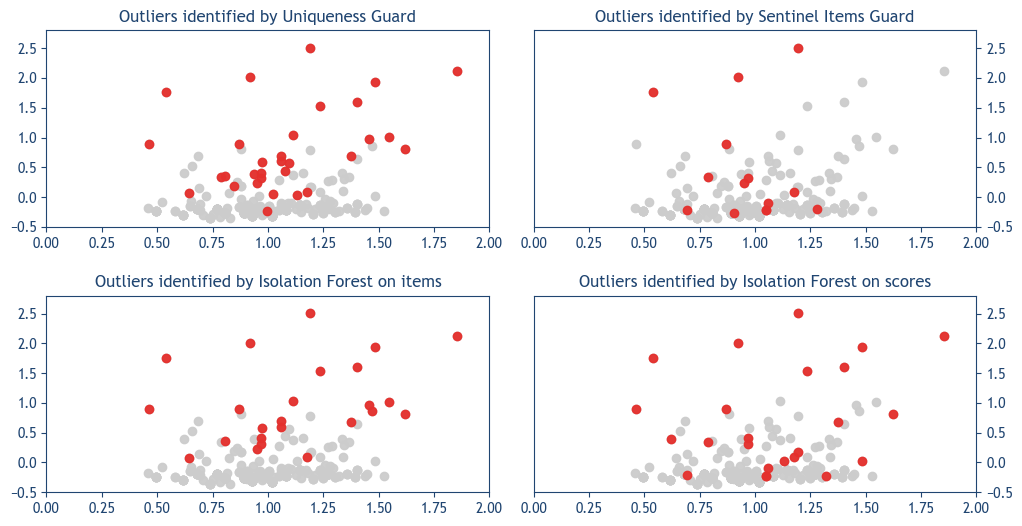

In [23]:
fig = plt.figure(figsize=(12,6))

gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ALPHA = .95

for algo, ax in zip(["uniqueness", "sentinel", "isof_items", "isof_parts"], [ax1, ax2, ax3, ax4]):
    outliers_mask =  data.loc[:, f"outlier_{algo}"] == -1
    ax.scatter(data["f1"], data["f2"], c="#ccc", alpha=ALPHA)
    ax.scatter(
        data.loc[outliers_mask, "f1"], 
        data.loc[outliers_mask, "f2"], 
        c="#e5302d", 
        alpha=ALPHA
    )
    #for index, row in data.copy().reset_index(drop=False).iterrows():
        #ax.annotate(row["bio_id"], (row["svd_f1"], row["svd_f2"]))
        
    
for idx, ax in enumerate([ax1, ax2, ax3, ax4], 1):
    if idx % 2 == 0: ax.yaxis.tick_right() 
    ax.set_xlim(0, 2)
    ax.set_ylim(-.5, 2.8)
    
    ax.tick_params(color=SPLINES_COLOR, labelcolor=SPLINES_COLOR)
    for spine in ax.spines.values():
        spine.set_edgecolor(SPLINES_COLOR)

ax1.set_title("Outliers identified by Uniqueness Guard", c=SPLINES_COLOR)
ax2.set_title("Outliers identified by Sentinel Items Guard", c=SPLINES_COLOR)
ax3.set_title("Outliers identified by Isolation Forest on items", c=SPLINES_COLOR)
ax4.set_title("Outliers identified by Isolation Forest on scores", c=SPLINES_COLOR)
        
plt.subplots_adjust(wspace=0.1, hspace=.35)
plt.savefig("./media/plot1.pdf", bbox_inches='tight')

## 4.3 Dist. of outlierness scores and plot of outliers with size prop. to strength scores

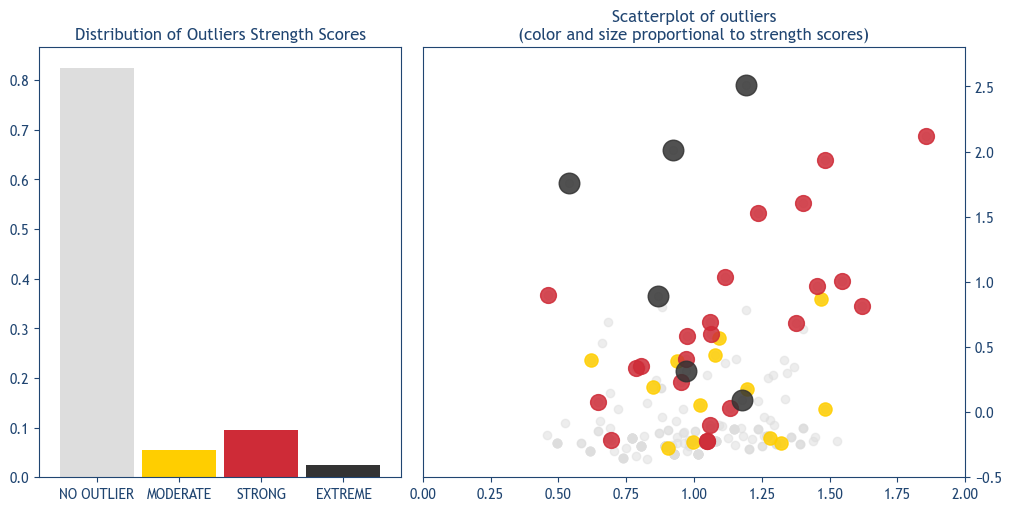

In [24]:
NO_OUTLIER_COLOR = "#DDDDDD"
MODERATE_OUTLIER_COLOR = "#ffce00"
STRONG_OUTLIER_COLOR = "#CE2B37"
EXTREME_OUTLIER_COLOR = "#333333"

fig = plt.figure(figsize=(10, 5), layout="constrained")

gs = GridSpec(1, 5, figure=fig)

# bar plot
ax1 = fig.add_subplot(gs[0, :2])
ax1_data = outlier_scores.squeeze().reindex(["no outlier", "moderate outlier","strong outlier","extreme outlier"])
(
    ax1_data
        .plot.bar(
         width=.9, 
         color = [NO_OUTLIER_COLOR,MODERATE_OUTLIER_COLOR,STRONG_OUTLIER_COLOR,EXTREME_OUTLIER_COLOR],
         ax=ax1
     )
)
ax1.set_xlabel("")
ax1.set_xticks(ax1.get_xticks(), ["NO OUTLIER","MODERATE","STRONG","EXTREME"], rotation=0)
ax1.set_title(f"Distribution of Outliers Strength Scores", c=SPLINES_COLOR);

# scatter plot
ax2 = fig.add_subplot(gs[0, 2:])
ax2.scatter(data["f1"], data["f2"], c="#DDDDDD", alpha=.5)

outliers_moderate = (data.filter(regex="outlier") == -1).sum(axis=1) == 1
outliers_strong = np.logical_or((data.filter(regex="outlier") == -1).sum(axis=1) == 2, (data.filter(regex="outlier") == -1).sum(axis=1) == 3)
outliers_extreme = (data.filter(regex="outlier") == -1).sum(axis=1) > 3

for outlier_mask, color, size in [ 
    (outliers_moderate, MODERATE_OUTLIER_COLOR, 90), 
    (outliers_strong, STRONG_OUTLIER_COLOR, 130),
    (outliers_extreme, EXTREME_OUTLIER_COLOR, 220)
]:
    ax2.scatter(
        data.loc[outlier_mask, "f1"], 
        data.loc[outlier_mask, "f2"], 
        s=size, 
        c=color,
        alpha=.85
    )
ax2.set_title(f"Scatterplot of outliers\n(color and size proportional to strength scores)", c=SPLINES_COLOR);
ax2.yaxis.tick_right();
ax2.set_xlim(0,2)
ax2.set_ylim(-.5,2.8);

for idx, ax in enumerate([ax1, ax2], 1):
    ax.tick_params(color=SPLINES_COLOR, labelcolor=SPLINES_COLOR)
    for spine in ax.spines.values():
        spine.set_edgecolor(SPLINES_COLOR)

plt.savefig("./media/plot2.pdf", bbox_inches='tight')


# 5. Use pre-trained pipe to compute outlierness score

### A word of caution to the reader

The subsequenct cells should go into another jupyter notebook. Here, they serve as an exmaple of computing the outlierness score of some unseen mhsc profile.

In [25]:
# pickle file path
MHSC_PIPE_FILEPATH = "./pickle/mhsc_pipe.pkl"
# check whteher pickle file exists
# open pickle file
with open(MHSC_PIPE_FILEPATH, 'rb') as fin:
    # load pickle object
    pipe = pickle.load(fin)

In [26]:
sample_mhsc = pd.DataFrame({
    "bio_id": [999999],
    "bio_gender": ["M"],
    "bio_age": ["17-30"],
    # Fatigue, weariness, difficulties in recovering from fatigue
    "mhsc_01_01": [0],	
    # Stress, feeling of being overwhelmed
    "mhsc_01_02": [0],	
    # Difficulties in controlling impulses
    "mhsc_01_03": [0],
    # Negative emotionality (e.g., tension, irritability, sadness, anxiety)
    "mhsc_01_04": [0],
    # Aggressiveness towards others or self
    "mhsc_01_05": [1],	
    # Concerns about private life
    "mhsc_01_06": [0],	
    # Difficulties in interpersonal relationships 
    "mhsc_01_07": [0],	
    # Concerns about job 
    "mhsc_01_08": [0],	
    # Health concerns 
    "mhsc_01_09": [0],	
    # Financial concerns 
    "mhsc_01_10": [0],
    # Energizing beverages (coffee, tea, energy drinks, ...) 
    "mhsc_02_01": [1],	
    # Alcoholic beverages 
    "mhsc_02_02": [1],	
    # Tobacco or tobacco-related products 
    "mhsc_02_03": [0],	
    # Light drugs (e.g., marijuana)
    "mhsc_02_04": [0],	
    #  Other drugs
    "mhsc_02_05": [0],
    #  Psychiatric or psychological treatments in progress or finished in the last year 
    "mhsc_03_01": [0],	
    # Access to corporate services dedicated to worker support (e.g., peer support) 
    "mhsc_03_02": [0],		
    # Inconveniences, dangerous events, accidents in the workplace in the last year 
    "mhsc_03_03": [0],
    # Other significant/relevant events in progress or occurred in the last year 
    "mhsc_03_04": [0],
    # Judicial/quasi-judicial/disciplinary proceedings in progress or closed in the last year
    "mhsc_03_05": [0],		
    # Using a scale from 0 (very low) to 10 (very high), rate your current psychological well-being
    "mhsc_04_01": [7],	
})

In [27]:
# compute outerlierness scores
pipe.run_pipe(sample_mhsc).T

,0
bio_id,999999
bio_gender,M
bio_age,17-30
mhsc_01_01,0
mhsc_01_02,0
mhsc_01_03,0
mhsc_01_04,0
mhsc_01_05,1
mhsc_01_06,0
mhsc_01_07,0
